# **Predicting the Location of the Product**

## Import Libraries & Dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('Dataset/train.csv',encoding='latin1')
target = train['Primary Site Code']
train = train.drop('Primary Site Code',axis=1)
test = pd.read_csv('Dataset/test.csv',encoding='latin1')
submission_columns = test['id']
test = test.drop('id',axis=1)
data = pd.concat([train,test],axis=0)

In [3]:
data.tail()

,Source System Code,SDW MPN Key,Product Number,Product Description,Minor Code
18995,LED_BAAN,094845.4A S18-AVL,094845.4A S18,TTEMP BATH BOARD A10B 100V,Unassigned
18996,LCD_INFOR_ROSKILDE,40916-ROS,40916,ENDESTYKKER SI,LPE Other Minor
18997,LED_BAAN,1223C22162200200-AVL,1223C22162200200,TF25 D A 208/60 T1 2.3KW AD+,TF 25
18998,LED_BAAN,091745-NEW,91745,SEISMIC/LEVEL FOOT MOUNT KIT,Unassigned
18999,LCD_INFOR_NEWPORT,2CRIS-NPT,2CRIS,CRYOVIAL 2.0ML INT SELF STAND,L650- Other Clinical Consumables


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29935 entries, 0 to 18999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Source System Code   29935 non-null  object
 1   SDW MPN Key          29935 non-null  object
 2   Product Number       29935 non-null  object
 3   Product Description  29880 non-null  object
 4   Minor Code           29935 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


### EDA & Feature Engineering

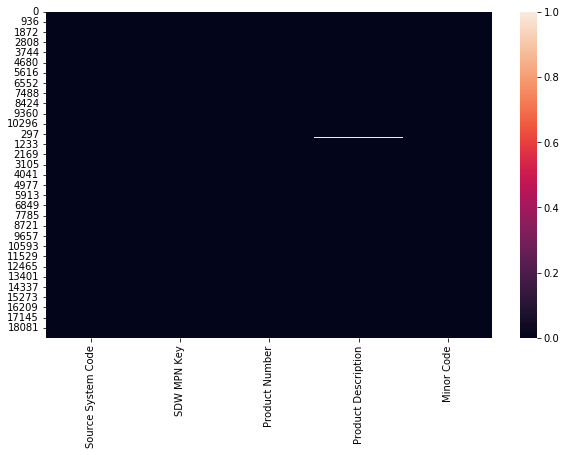

In [5]:
## checking for null values
plt.figure(figsize=(10,6))
sns.heatmap(data.isnull())

In [6]:
data['Source System Code'].value_counts()

LED_BAAN                12997
LSB                      3456
LCD_INFOR_NEWPORT        2514
OXAION                   2416
LED_SYSPRO_SINGAPORE     2118
GBL                      1942
ISCALA_FIN               1816
LCD_INFOR_ROSKILDE       1057
LCD_MACOLA                572
ROC                       305
AMPK                      263
EDW_E1                    241
ISCALA_RUS                204
PRMS_RFD                   31
LCD_SYSPRO_AUBURN           2
LCD_SYSPRO_ROCKWOOD         1
Name: Source System Code, dtype: int64

In [7]:
data['Source System Code_0'] = data['Source System Code'].apply(lambda x: x.split('_')[0])

In [8]:
data['Source System Code_0'].value_counts()

LED       15115
LCD        4146
LSB        3456
OXAION     2416
ISCALA     2020
GBL        1942
ROC         305
AMPK        263
EDW         241
PRMS         31
Name: Source System Code_0, dtype: int64

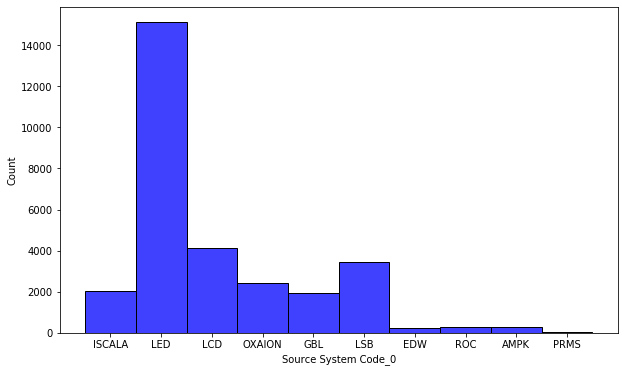

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(data['Source System Code_0'],color='b')

In [10]:
data['Minor Code'].value_counts().sort_values(ascending=False).head(50)

Unassigned                             10190
3K20- SP&A Parts/Acc                    1550
TC Service Other Service Parts          1281
Centrifuge Service Minor                 962
TF 14                                    926
TF 25                                    839
Temp Control Service Minor               700
3F20- Pipette Parts                      694
TF 9                                     464
Water Purification MjC MC                459
L207- Misc Newport                       440
Water Analysis Service Minor             309
LPE Other Minor                          299
TC Accessories MjC MC                    295
WAI Misc Lab                             262
3K21- SP&A Parts/Acc                     244
L702- Npt Contain                        233
Ancillary Service Minor                  224
Misc Lab Products MjC MC                 192
Labware and Bottles MjC MC               179
Stirrers and Hot Plates MjC MC           174
LPH2- pH/ORP Sensors                     152
BSC/CO2 Se

In [11]:
target.replace(np.nan,'NaN',inplace=True)

In [12]:
#getting only last word from SDW MPN Key column since the first part is related to prodcut number
data['SDW MPN Key_last']= data['SDW MPN Key'].apply(lambda x: x.split('-')[-1])
data.drop('SDW MPN Key',axis=1,inplace=True)

In [13]:
## label encoding
le=LabelEncoder()
target = le.fit_transform(target)

le_1 =LabelEncoder()
data['SDW MPN Key_last_labels'] = le_1.fit_transform(data['SDW MPN Key_last'])
data.drop('SDW MPN Key_last',axis=1, inplace = True)

le_2 = LabelEncoder()
data['Source System Code_0'] = le_2.fit_transform(data['Source System Code_0'])

le_3 = LabelEncoder()
data['Minor_Code_labels']=le_3.fit_transform(data['Minor Code'])
data.drop('Minor Code',axis=1,inplace=True)

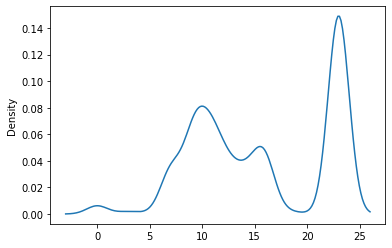

In [14]:
#distribution of target variables
sns.kdeplot(target)

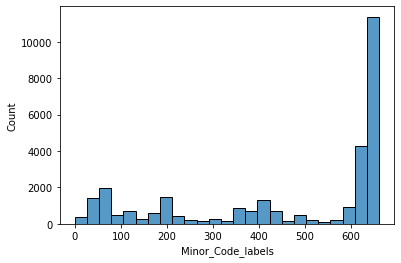

In [15]:
sns.histplot(data['Minor_Code_labels'])

In [16]:
data['Product Description'].isnull().sum()

55

In [17]:
#getting only numbers from prdouct number column
data['Numbers'] = [''.join(re.findall(r'\d+',i)) for i in data['Product Number']]

data['Numbers'].replace('',np.nan,inplace=True)
data['Numbers'].fillna(data['Numbers'].mode()[0],inplace=True)
data['Numbers'] = data['Numbers'].astype('int64') 

In [18]:
data.drop('Product Number',axis=1,inplace=True)
data.drop('Product Description',axis=1,inplace=True)

In [19]:
## categorical encoding (can also use one hot encoding)
dum = pd.get_dummies(data['Source System Code'],drop_first=True)
data = pd.concat([dum,data],axis=1)
data.drop('Source System Code',axis=1,inplace=True)

In [20]:
data.head()

,EDW_E1,GBL,ISCALA_FIN,ISCALA_RUS,LCD_INFOR_NEWPORT,LCD_INFOR_ROSKILDE,LCD_MACOLA,LCD_SYSPRO_AUBURN,LCD_SYSPRO_ROCKWOOD,LED_BAAN,LED_SYSPRO_SINGAPORE,LSB,OXAION,PRMS_RFD,ROC,Source System Code_0,SDW MPN Key_last_labels,Minor_Code_labels,Numbers
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,55,59,9402159
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,3,644,12586100000
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,35,131,228
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,35,131,1000
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,33,644,12411


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29935 entries, 0 to 18999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   EDW_E1                   29935 non-null  uint8
 1   GBL                      29935 non-null  uint8
 2   ISCALA_FIN               29935 non-null  uint8
 3   ISCALA_RUS               29935 non-null  uint8
 4   LCD_INFOR_NEWPORT        29935 non-null  uint8
 5   LCD_INFOR_ROSKILDE       29935 non-null  uint8
 6   LCD_MACOLA               29935 non-null  uint8
 7   LCD_SYSPRO_AUBURN        29935 non-null  uint8
 8   LCD_SYSPRO_ROCKWOOD      29935 non-null  uint8
 9   LED_BAAN                 29935 non-null  uint8
 10  LED_SYSPRO_SINGAPORE     29935 non-null  uint8
 11  LSB                      29935 non-null  uint8
 12  OXAION                   29935 non-null  uint8
 13  PRMS_RFD                 29935 non-null  uint8
 14  ROC                      29935 non-null  uint8
 15  So

## Splitting the Data

In [22]:
train_x = data[:len(train)]
test_x = data[len(train):]

X_train, X_val, y_train, y_val = train_test_split(train_x,target,test_size=0.2,random_state=0)

## Building Model and Evaluation

In [23]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],verbose=0)
accuracy_score(xgb.predict(X_val),y_val)

0.9693644261545497

In [24]:
pred = xgb.predict(test_x)
sub = pd.DataFrame({'id':submission_columns,'Primary Site Code':le.inverse_transform(pred)})

In [25]:
le.inverse_transform(pred)

array(['E03', 'U71', 'EDK', ..., 'U71', 'U71', 'EGN'], dtype=object)

In [ ]:
sub.to_csv('final_preds.csv',index=False)